## MLP : Multi Layer Perceptron
Let's try to build a multi-layer Neutal net using TensorFlow. Here, I will create a hand-written digits classifier using the popular dataset: __[MNIST](http://yann.lecun.com/exdb/mnist/)__. The __[MNIST dataset](http://yann.lecun.com/exdb/mnist/)__ contains 60,000 training examples and 10,000 test examples of the handwritten digits 0–9, formatted as 28x28-pixel images. First, let's visualize some MNIST examples:

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting tmp/data/t10k-labels-idx1-ubyte.gz


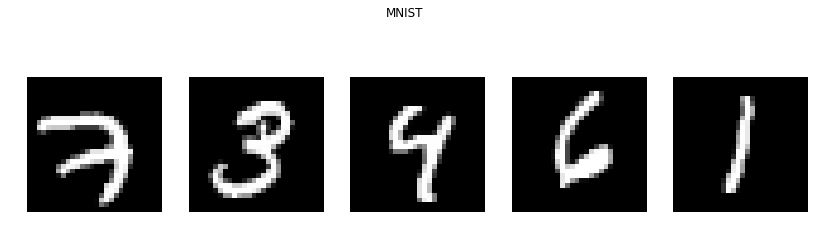

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data # import MNIST data

mnist = input_data.read_data_sets("tmp/data/", one_hot=True) # will download about 11 MB

# X_train = mnist.train.images
# y_train = mnist.train.labels
# print(X_train.shape, y_train.shape)

# X_test = mnist.validation.images
# y_test = mnist.validation.labels
# print(X_test.shape, y_test.shape)

# plot 5 images from MNIST
f = plt.figure(figsize = (14,4))
f.suptitle('MNIST')
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(mnist.train.images[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
plt.show()

print(mnist.train.labels[:5,:])

## The Model
#### or should I say: the Computational Graph
Let's build a model to classify the images in the MNIST dataset using the following architecture:
- Input Layer: shape = (100,784) ==> 100 image (minibatch), each has 784 pixels
- Fully connected (Dense) Layer #1: 256 neurons, with ReLU activation function:
    - weights shape = (784,256) - bais shape = (256) - output (X*W+b) shape = (100,256)
- Fully connected (Dense) Layer #2: 128 neurons, with ReLU activation function
    - weights shape = (256,128) - bais shape = (128) - output (X*W+b) shape = (100,128)
- Output Layer: 10 neurons (bcz 10 classes), with Softmax
    - weights shape = (128,10) - bais shape = (10) - output (X*W+b) shape = (100,10)
<img src="images/MNIST_MLP.png" alt="Tensors" title="Tensors" height="420" width="720"/>

Weights initialised with small random values between -0.2 and +0.2 <br>
This will be done using **truncated_normal** function: <br>
> The generated values follow a normal distribution with specified mean and standard deviation, except that values whose magnitude is more than 2 standard deviations from the mean are dropped and re-picked.

The point is to overcome saturation of tome functions like sigmoid (where if the value is too big/small, the neuron stops learning). <br>
When using RELUs, make sure biases are initialised with small *positive* values. for example 0.1 <br>
__[Stanford](http://cs231n.github.io/neural-networks-2/#init)__ claims:
> this ensures that all ReLU units fire in the beginning and therefore obtain and propagate some gradient.

In [5]:
def feed_forward(X, w, b): # input, times weight, add bais, activate
    # hidden layer 1
    layer_1 = tf.matmul(X, w['h1']) # multiply input by weight
    layer_1 = tf.add(layer_1, b['h1']) # add bais
    layer_1 = tf.nn.relu(layer_1) # activate
    # hidden layer 2
    layer_2 = tf.matmul(layer_1, w['h2']) # multiply input by weight
    layer_2 = tf.add(layer_2, b['h2']) # add bais
    layer_2 = tf.nn.relu(layer_2) # activate
    # output layer
    output_layer = tf.matmul(layer_2, w['output']) # multiply input by weight
    output_layer = tf.add(output_layer, b['output']) # add bais
    #output = tf.nn.softmax(output_layer) # activate
    return output_layer

tf.reset_default_graph()
# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 128 # 2nd layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
learning_rate = 0.0005
batch_size = 100
epochs = 10

# weights & baises as tensorflow trainable variables
weights = {
    'h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1], stddev=0.1), name='w1'),
    'h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=0.1), name='w2'),
    'output': tf.Variable(tf.truncated_normal([n_hidden_2, n_classes], stddev=0.1), name='w_output')
}
bais = {
    'h1': tf.Variable(tf.ones([n_hidden_1]) / 10 , name='b1'),
    'h2': tf.Variable(tf.ones([n_hidden_2]) / 10, name='b2'),
    'output': tf.Variable(tf.ones([n_classes]) / 10, name='b_output')
}

# tf Graph input as placeholders
X = tf.placeholder(tf.float32, [None, n_input], name='X')
y = tf.placeholder(tf.int32, [None, n_classes], name='y')

# tf Graph output
y_hat = feed_forward(X, weights, bais)

## The loss function: Cross-Entropy
We have to compare the softmax probabilities and one-hot encoded target vector for similarity. The Cross-entropy is a distance calculation function which takes the calculated probabilities from softmax function and the created one-hot-encoding matrix to calculate the distance. For the right target classes, the distance values will be lesser, and the distance values will be larger for the wrong target classes. We define cross entropy, **D(S,T)**, for i th observation with softmax probability vector (S) and one-hot target vector (T) as:
<img src="images/cross_entropy.gif" alt="cross_entropy" title="cross_entropy" height="220" width="220"/>
And now, cost function, J can be defined as the average cross entropy:
<img src="images/avg_cross_entropy.gif" alt="cross_entropy" title="cross_entropy" height="220" width="220"/>

In [6]:
# define loss function
y = tf.to_float(y)
softmax = tf.nn.softmax(y_hat)
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(softmax), reduction_indices=[1]))

# fortunately, TensorFlow is shipped with cross-entorpy function
#cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat))

# define optiminizer (Gradient Descent) to minimize loss function
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

# define accuracy
correct_prediction = tf.equal(tf.argmax(softmax, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

## Training: Batch gradient descent

In [35]:
# Training steps
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    epochs = 30
    for epoch in range(epochs):
        _, c, a = sess.run([train_step, cross_entropy, accuracy], feed_dict={X: mnist.train.images, y: mnist.train.labels})
        print('epoch:', epoch+1, 'cost:', c, 'accuracy:', a)
    print("Optimization Finished!")

epoch: 1 cost: 2.49211 accuracy: 0.0904545
epoch: 2 cost: 2.22513 accuracy: 0.151091
epoch: 3 cost: 2.02667 accuracy: 0.2956
epoch: 4 cost: 1.85404 accuracy: 0.428727
epoch: 5 cost: 1.69129 accuracy: 0.532618
epoch: 6 cost: 1.53524 accuracy: 0.607655
epoch: 7 cost: 1.38745 accuracy: 0.6648
epoch: 8 cost: 1.25083 accuracy: 0.711691
epoch: 9 cost: 1.12832 accuracy: 0.743364
epoch: 10 cost: 1.02077 accuracy: 0.764491
epoch: 11 cost: 0.926335 accuracy: 0.781018
epoch: 12 cost: 0.842251 accuracy: 0.795509
epoch: 13 cost: 0.768158 accuracy: 0.807273
epoch: 14 cost: 0.705146 accuracy: 0.817691
epoch: 15 cost: 0.652521 accuracy: 0.826345
epoch: 16 cost: 0.607425 accuracy: 0.8336
epoch: 17 cost: 0.567976 accuracy: 0.841709
epoch: 18 cost: 0.534133 accuracy: 0.849982
epoch: 19 cost: 0.50544 accuracy: 0.857164
epoch: 20 cost: 0.480323 accuracy: 0.863945
epoch: 21 cost: 0.458022 accuracy: 0.8694
epoch: 22 cost: 0.439022 accuracy: 0.874255
epoch: 23 cost: 0.422832 accuracy: 0.878491
epoch: 24 cost:

## Training: Mini Batch gradient descent

In [7]:
saver = tf.train.Saver() # to save the model weights

# Training steps
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    epochs = 10
    for epoch in range(epochs):
        cost = []
        number_of_batchs = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(number_of_batchs):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            _, c = sess.run([train_step, cross_entropy], feed_dict={X: batch_x, y: batch_y})
            cost.append(c)
        a = sess.run(accuracy, feed_dict={X: mnist.train.images, y: mnist.train.labels})
        print('epoch:', epoch+1, 'cost:', (sum(cost)/len(cost)), 'accuracy:', a)
    print("Optimization Finished!")
    # training is over. save the model weights
    saver.save(sess, 'models/mnist_mlp_2_hidden')
    print("Model saved!")
    # evaluate
    a = sess.run(accuracy, feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
    print("test accuracy:", a)
    y_pred = sess.run(y_hat, feed_dict={X: mnist.validation.images})

epoch: 1 cost: 0.358579063788 accuracy: 0.952255
epoch: 2 cost: 0.142075968148 accuracy: 0.970418
epoch: 3 cost: 0.0961399432814 accuracy: 0.977891
epoch: 4 cost: 0.0712600432717 accuracy: 0.985055
epoch: 5 cost: 0.0537366390652 accuracy: 0.989764
epoch: 6 cost: 0.0405609607002 accuracy: 0.992055
epoch: 7 cost: 0.0307692520879 accuracy: 0.993618
epoch: 8 cost: 0.0246169317306 accuracy: 0.991418
epoch: 9 cost: 0.0190353194774 accuracy: 0.9952
epoch: 10 cost: 0.0153427363642 accuracy: 0.997964
Optimization Finished!
Model saved!
test accuracy: 0.9804


## Predict

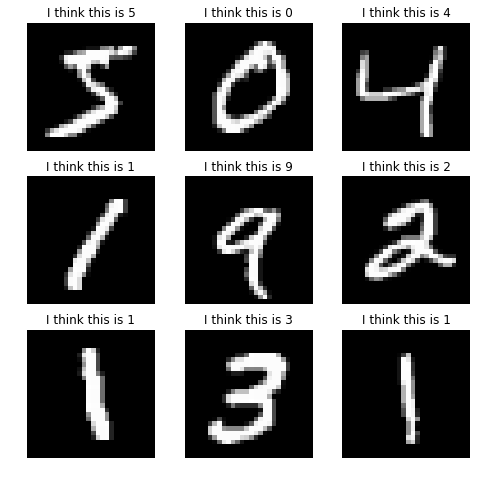

In [8]:
idx = np.argmax(y_pred, 1)
fig = plt.figure(figsize = (8,8))
for i in range (9):
    ax = plt.subplot("33"+str(i+1))
    ax.set_title('I think this is ' + str(idx[i]))
    ax.imshow(mnist.validation.images[i].reshape((28,28)), cmap='gray')
    ax.axis('off')
plt.show()

## TensorBoard

In [9]:
writer = tf.summary.FileWriter('.')
writer.add_graph(tf.get_default_graph())

Now, in a new terminal, launch TensorBoard with the following shell command: <br>
`tensorboard --logdir .` <br>
OR <br>
`python -m tensorflow.tensorboard --logdir .` <br>
Then go to __[localhost:6006](http://localhost:6006)__ to **GRAPHS** tab to see the computational graph
<img src="images/MLP_graph.png" alt="MLP_graph" title="MLP_graph" height="820" width="720"/>